In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_excel(PATH OF THE EXCEL FILE) # CHANGE THIS LINE 

print("Shape of dataframe", raw_data.shape) 

data = raw_data[['name', 'founded_on', 'num_employees_max', 'num_employees_min', 'total_funding_usd',
               'number_of_investments', 'headquarters_id_vlookup']]

# Check for missing values 
for x in data.columns:
    if data[x].isnull().values.any():
        print (data[x].isnull().values.sum(), "blanks in", x)

Shape of dataframe (6191, 65)
3680 blanks in founded_on
5084 blanks in num_employees_max
5084 blanks in num_employees_min
2702 blanks in total_funding_usd
2702 blanks in number_of_investments
2788 blanks in headquarters_id_vlookup


There are around 6200 Australian companies and 65 features in the database. Most of these features are not useful for the analysis. The reduced data set contains information about the company name, founding date, maximum and minimum number of employees, total funding, number of investments and the location of headquarters. There are thousands of missing values among these important features!

In [3]:
# Replace blanks in total_funding & no_of_investments with ZERO
data['number_of_investments'].fillna(0)
data['total_funding_usd'].fillna(0)

# Select only the rows which don't have blanks for no. employees
data_small = data.dropna(subset=['num_employees_min'])

# Make sure there are no blanks in num_employees_max
print(data_small['num_employees_max'].isnull().values.any())


#-------------------------------
# Calculate the age of companies
#------------------------------

# Drop NaNs in 'founded_on' colummn
data_small = data_small.dropna(subset=['founded_on'])


# Convert to the standard datatime format

import datetime as dt

data_small['founded_on'] = pd.to_datetime(data_small['founded_on'], errors='coerce')
data_small = data_small.dropna(subset=['founded_on'])

presentYr = dt.date.today().year

data_small['age'] = presentYr - data_small.founded_on.dt.year

print("Number of companies in the final dataframe", data_small.shape[0])

False
Number of companies in the final dataframe 960


In the above step, the companies which do not have data regarding the number of employees and the founding date have been ignored. If there is no information regarding the number of investments and total funding, replace the blanks with zeros. Later, calculate the age of the company based on its founding date.

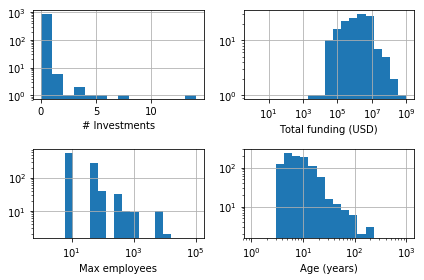

In [4]:
#-------------------------- 
# Preliminary Exploratory Data Analysis (EDA)
#--------------------------

fig1, ax1 = plt.subplots(nrows=2,ncols=2)

data_small.number_of_investments.hist(ax=ax1[0,0], log=True, bins=int(data_small.number_of_investments.max()))
ax1[0,0].set_xlabel('# Investments')

data_small['total_funding_usd'].hist(ax=ax1[0,1], log=True, bins=np.logspace(0,9,20))
ax1[0,1].set_xlabel('Total funding (USD)')
ax1[0,1].set_xscale("log")

data_small.num_employees_max.hist(ax=ax1[1,0], log=True, bins=np.logspace(0,5,20))
ax1[1,0].set_xlabel('Max employees')
ax1[1,0].set_xscale("log")

data_small.age.hist(ax=ax1[1,1], log=True, bins=np.logspace(0,3,20))
ax1[1,1].set_xlabel('Age (years)')
ax1[1,1].set_xscale("log")

fig1.tight_layout()

plt.show()

Plot the histograms of all the quantitative data. The preliminary EDA shows that the dataframe has companies which have more than 5 investments or $50 million dollar funding or 500 employees or more than 15 years old. These are not the qualities of a small startup and the companies belonging to one of these categories are discarded for further analysis.

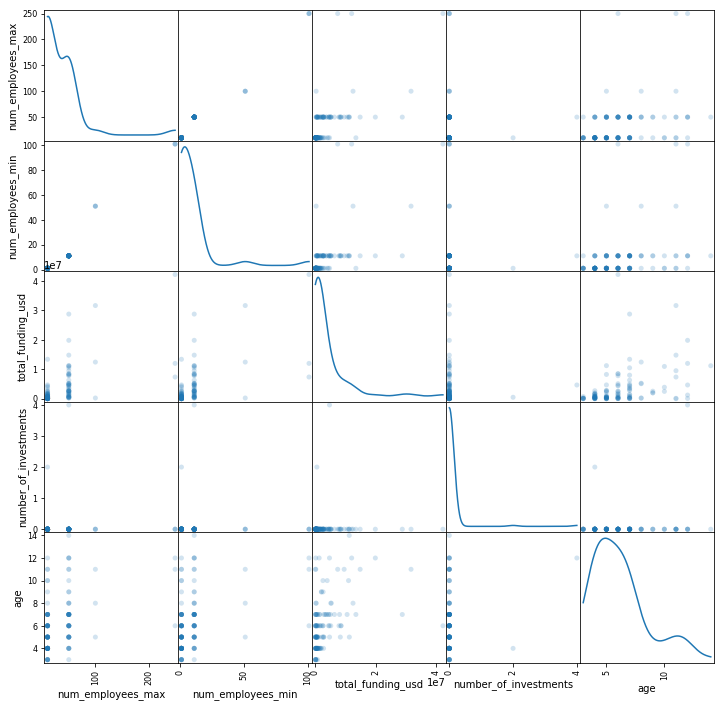

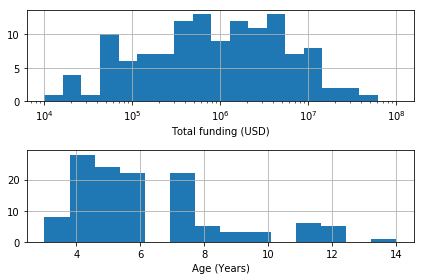

In [5]:
#-----------------
# Further Analysis
#-----------------

data_2=data_small.loc[ (data_small['num_employees_min'] < 500) & (data_small['total_funding_usd'] < 5e7) \
                     & (data_small['total_funding_usd'] > 0) & (data_small['number_of_investments'] <= 5) & (data_small['age'] <15) ]
               

# Check for RELATIONSHIP between variables

from pandas.plotting import scatter_matrix

scatter_matrix(data_2, alpha=0.2, diagonal = 'kde', s=100, figsize=(12, 12))

fig2, ax2=plt.subplots(nrows=2)

data_2['total_funding_usd'].hist(ax=ax2[0], log=False, bins=  np.logspace(4,8,20))
ax2[0].set_xlabel('Total funding (USD)')
ax2[0].set_xscale("log")

data_2['age'].hist(ax=ax2[1], log=False, bins=max(data_2['age']))
ax2[1].set_xlabel('Age (Years)')

fig2.tight_layout()

plt.show()

The scatter matrix plot shows that there is correlation only between the age of a company and its total funding. The total funding has better PDF (probability density function) on a log scale. 

The next step is to build a predictive model based on these features. The basic aim is to predict how much funding a startup can receive based on its age. A linear regression model is chosen for this work since there is an approximate linear correlation between the logarithm of funding and the age.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: reshape is deprecated and will raise in a subsequent r

Mean Squared Error of Linear regression is 0.573046985376


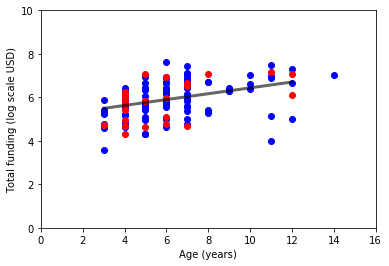

In [6]:
#--------------
# Model fitting: LINEAR REGRESSION using sklearn
#--------------

# Transform funding to log scale. 

Y_data = np.log10(data_2['total_funding_usd'])
X_data = data_2['age']


# Splitting the data to test and train

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_data, Y_data, train_size=0.8, random_state=10)


# Setting up the model

from sklearn import linear_model
lr = linear_model.LinearRegression(normalize=True)


# Model fitting and prediction
# reshape the X data since there is only one feature. Gives error otherwise

lr.fit(X_train.reshape(-1,1),y_train)

y_lr = lr.predict(X_test.reshape(-1,1))


# Evaluation

from sklearn.metrics import mean_squared_error
print('Mean Squared Error of Linear regression is', mean_squared_error(y_test,y_lr))


# Plotting

fig4, ax4 =plt.subplots(ncols=1)
ax4.scatter(X_train,y_train,c='b')
ax4.scatter(X_test,y_test,c='r')


# Sorting the values to plot the linear graph predicted by linear regression model

x_sort=X_test.sort_values()  # sort_values() is for pandas
y_lr.sort()   # sort() is for numpy

ax4.plot(x_sort,y_lr,color='k', linestyle='-', linewidth=3, alpha=0.6)
ax4.set_xlabel('Age (years)', fontsize=10)
ax4.set_ylabel('Total funding (log scale USD)', fontsize=10)
ax4.set(xlim=[0,16], ylim=[0,10])

plt.show()


In the above figure, the black line is the linear regression line, blue dots represent the training data set and the red dots represent the test data set. It is seen that the model captures the trend accurately .i.e. the startup companies tend to get more funding with increase in their age. However, it has to be noted that the scatter of data around this line is quite high due to which the predictions from this model should be handled with caution. 

Further analysis regarding the conditional mean of funding conditioned on the age of the company and the conditional variance can be analyzed to get more insights.

In spite of its variability, the above statistical data could be used to predict the future of a company's funding. For instance, if a company is 3 years old and has received 10,000 USD funding, it can be predicted to achieve a minimum funding of 100,000 USD and maximum of 5 million USD after 3 more years. On the other hand, if a company has already secured a funding of 1 million USD within 3 years of its inception, the probability of that company getting more funding in the next few years will be low.

NOTE: These inferences hold good only for the Australian companies.